In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download ocular disease recognition dataset
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

ocular-disease-recognition-odir5k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Extract the data
import zipfile

zip_ref = zipfile.ZipFile('ocular-disease-recognition-odir5k.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [6]:
# !pip install tensorflow-gpu==2.8.3
# !pip install tensorflow-addons==0.17.1
!pip install tensorflow-addons==0.21.0

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers
import tensorflow_addons as tfa
import keras.backend as K
import random
from time import time
from datetime import datetime

2.13.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

In [9]:
import pandas as pd

new_df = pd.read_json("/content/gdrive/MyDrive/Opthamologist/label_prepared.json")
# new_df = pd.read_hdf("/content/gdrive/MyDrive/Colab Notebooks/output.h5", key="data")
# new_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/output.csv')
new_df

,filename,keywords,label
0,0_left.jpg,[cataract],[C]
1,1_left.jpg,[normal fundus],[N]
2,2_left.jpg,"[laser spot, moderate non proliferative retino...","[O, D]"
3,3_left.jpg,[normal fundus],[N]
4,4_left.jpg,[macular epiretinal membrane],[O]
...,...,...,...
6563,4686_right.jpg,[proliferative diabetic retinopathy],[D]
6564,4688_right.jpg,[moderate non proliferative retinopathy],[D]
6565,4689_right.jpg,[normal fundus],[N]
6566,4690_right.jpg,[mild nonproliferative retinopathy],[D]


In [10]:
#define croping function with tensorflow resize
def crop_image(image_path):
  image_data = tf.keras.preprocessing.image.load_img(image_path)

  array = tf.keras.preprocessing.image.img_to_array(image_data)
  image = tf.image.resize(
                        array, [200,200],
                        method='bilinear',
                        preserve_aspect_ratio=True,
                        antialias=False,
                        )
  # image = image / 255.0
  return image

In [11]:
#define method for image resize, croping and image Contrast Limited Adaptive Histogram Equalization (CLAHE)
#using Opencv 4

def image_resize(image_path, dim):
  img = cv2.imread(image_path)
  if img.shape[1] != img.shape[0]:
    x = img.shape[1]//2
    y = img.shape[0]//2
    x = x-y
    img = img[0:0+img.shape[0], x:x+img.shape[0]]
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def CLAHE(image_path, dim, clipLimit, tileGridSize):
  img = image_resize(image_path, dim)
  clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
  l, a, b = cv2.split(lab)  # split on 3 different channels
  l2 = clahe.apply(l)  # apply CLAHE to the L-channel
  lab = cv2.merge((l2,a,b))  # merge channels
  img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

(1, 198, 200, 3)

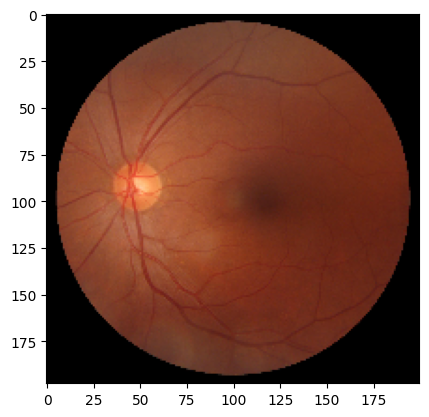

In [12]:
#before CLAHE processing
source = '/content/files/ODIR-5K/ODIR-5K/Training Images/112_left.jpg'
test = crop_image(source)
test = np.array(test)
img = tf.keras.preprocessing.image.array_to_img(test)
plt.imshow(img)
test = np.expand_dims(test, axis=0)
test.shape

(1, 200, 200, 3)

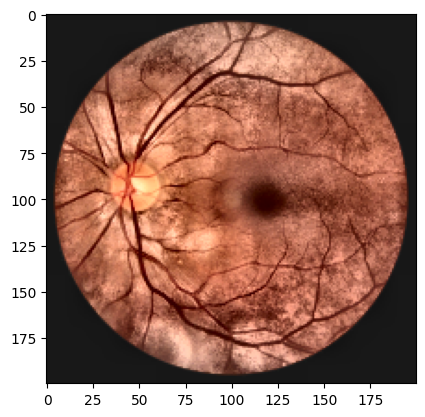

In [13]:
#showing CLAHE image Preprocessing
source = '/content/files/ODIR-5K/ODIR-5K/Training Images/112_left.jpg'
test = CLAHE(source, (200,200), 20, (10,10))
test = np.array(test)
img = tf.keras.preprocessing.image.array_to_img(test)
plt.imshow(img)
test = test.reshape(1, 200, 200, 3)
test.shape

In [14]:
#set target size image

target_size = (230, 230)
# color_mode = 'grayscale'
color_mode = 'rgb'
if color_mode == 'grayscale':
  shapeadd = (1,)
if color_mode == 'rgb':
  shapeadd = (3,)

In [15]:
# Delete image that is not in the dataframe
unlisted = []

for image in os.listdir('/content/files/ODIR-5K/ODIR-5K/Training Images'):
  if image in new_df['filename'].values.tolist():
    continue
  else:
    unlisted.append(image)

print(unlisted)

for image in unlisted:
  os.remove('/content/files/ODIR-5K/ODIR-5K/Training Images/' + image)

['1455_left.jpg', '2214_left.jpg', '2893_left.jpg', '267_right.jpg', '2247_right.jpg', '3947_right.jpg', '2694_left.jpg', '2244_left.jpg', '1140_right.jpg', '3037_left.jpg', '1456_right.jpg', '1401_left.jpg', '460_right.jpg', '465_left.jpg', '2756_left.jpg', '2213_left.jpg', '3154_left.jpg', '70_right.jpg', '3060_right.jpg', '4198_right.jpg', '2741_right.jpg', '201_left.jpg', '1121_left.jpg', '2350_left.jpg', '2516_left.jpg', '2494_left.jpg', '867_right.jpg', '409_left.jpg', '3039_right.jpg', '2536_right.jpg', '3402_right.jpg', '2759_right.jpg', '3256_left.jpg', '2357_left.jpg', '1137_right.jpg', '3133_right.jpg', '577_left.jpg', '2251_right.jpg', '2739_left.jpg', '1968_left.jpg', '1134_left.jpg', '124_right.jpg', '3239_right.jpg', '3053_right.jpg', '2241_right.jpg', '2968_right.jpg', '184_left.jpg', '2606_left.jpg', '1999_left.jpg', '2840_left.jpg', '3265_left.jpg', '2694_right.jpg', '3349_right.jpg', '2851_left.jpg', '2453_right.jpg', '2450_left.jpg', '222_right.jpg', '1409_right.jpg

In [16]:
# Fit the multi-label binarizer on the training set
print("Labels:")
bin_label = list(new_df['label'])
mlb.fit(bin_label)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))


Labels:
0. A
1. C
2. D
3. G
4. H
5. M
6. N
7. O


In [17]:
mlb.classes_

array(['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O'], dtype=object)

In [18]:
# transform the targets of the training and test sets
bin_label = mlb.transform(bin_label)

In [19]:
len(bin_label)

6568

In [20]:
# Create a list containing path to locate images

filenames = [os.path.join('/content/files/ODIR-5K/ODIR-5K/Training Images', str(f)) for f in new_df['filename']]
filenames[:3]

['/content/files/ODIR-5K/ODIR-5K/Training Images/0_left.jpg',
 '/content/files/ODIR-5K/ODIR-5K/Training Images/1_left.jpg',
 '/content/files/ODIR-5K/ODIR-5K/Training Images/2_left.jpg']

In [21]:
from tqdm import tqdm

# Create a list containing CLAHE images
images = []

# Wrap the loop with tqdm to create a progress bar
for name in tqdm(filenames, desc="Processing images"):
    images.append(CLAHE(name, target_size, 20, (10, 10)))

Processing images: 100%|██████████| 6568/6568 [06:21<00:00, 17.21it/s]


In [22]:
images = np.stack(images, axis=0)

training_features, temp_validation_features, training_labels, temp_validation_labels, training_filenames, temp_validation_filenames, training_key, temp_validation_key = train_test_split(images, bin_label, filenames, new_df['label'].values.tolist(), test_size=0.102, random_state=1)

validation_features, validation_test_features, validation_labels, validation_test_labels, validation_filenames, validation_test_filenames, validation_key, validation_test_key = train_test_split(temp_validation_features, temp_validation_labels, temp_validation_filenames, temp_validation_key, test_size=0.02, random_state=1)

print("n training :", len(training_filenames))
print("n validation :", len(validation_filenames))
print("n validation test :", len(validation_test_filenames))

#delete temporary list file for minimalizing memory usage
del images
del bin_label
del temp_validation_features
del temp_validation_labels
del temp_validation_filenames

n training : 5898
n validation : 656
n validation test : 14


Training images: 



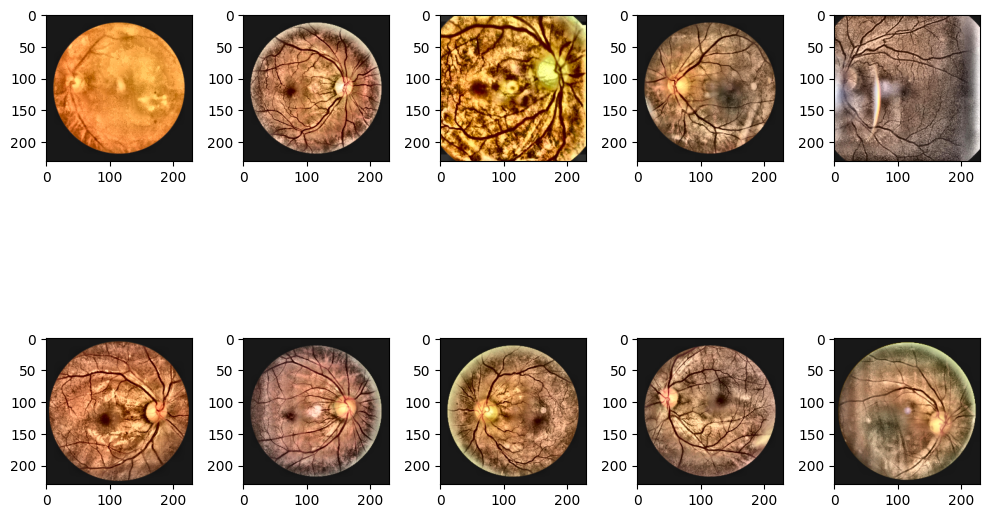

In [23]:
print('Training images: \n')
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        if color_mode == 'rgb':
          ax[i,j].imshow(training_features[k].reshape(target_size[0], target_size[1], 3) , cmap = "hsv")
        else :
          ax[i,j].imshow(training_features[k].reshape(target_size[0], target_size[1]) , cmap = "gray")
        k += 1
    plt.tight_layout()

Validation images: 



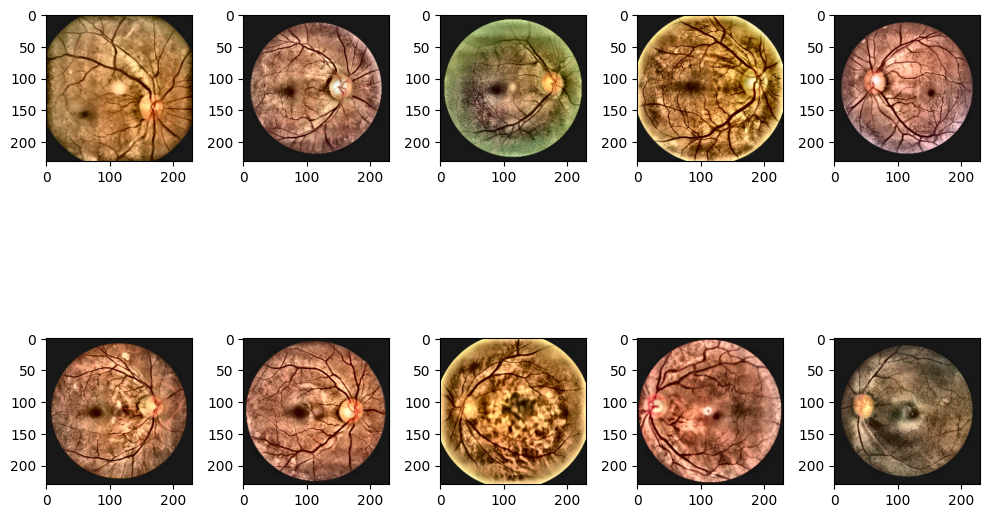

In [24]:
print('Validation images: \n')
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(validation_features[k].reshape(target_size[0], target_size[1], 3) , cmap = "hsv")
        k += 1
    plt.tight_layout()

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True,
                                   #fill_mode='nearest'
                                   )

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(training_features,
                                     y=training_labels,
                                     batch_size=32,
                                     )

validation_generator = validation_datagen.flow(validation_features,
                                               y=validation_labels,
                                               batch_size=32
                                               )

In [26]:
# Create the base model from the pre-trained model MobileNet V2
input_shape = target_size + shapeadd
base_model = tf.keras.applications.VGG16(input_shape=input_shape,
                                         include_top=False,
                                         weights='imagenet')


In [27]:
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(8, activation='sigmoid')
    ])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 40414024 (154.17 MB)
Trainable params: 25699336 (98.04 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [28]:
# Set callback
checkpoint_path = "/content/gdrive/MyDrive/Opthamologist/Trained Models/ODIR5K.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1)

stopAccuracy = 0.90

# Define a Callback class that stops training once accuracy reaches the certain accuracy
class callbackStop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy_multilabel')>stopAccuracy):
      print("\nReached", stopAccuracy*100, " accuracy so cancelling training!")
      self.model.stop_training = True

callbackstop = callbackStop()


# Define early stopping callback with patience and delta
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy_multilabel',  # Monitor validation accuracy
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,  # Minimum change in monitored quantity to be considered as an improvement
    verbose=1  # Print messages when training stops
)

In [29]:
AUC_value = tf.keras.metrics.AUC( curve='ROC', summation_method='interpolation', multi_label=True)
F1_score = tfa.metrics.F1Score(num_classes=8, name='F-1 score', average='macro', threshold=0.5)

In [30]:
@tf.function
def accuracy_multilabel(y, y_hat):
  correct_prediction = tf.equal(tf.round(y_hat), y)
  # correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(y_hat)), tf.round(y))
  ##mean
  correct_prediction = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  ##all
  # all_labels_true = tf.reduce_min(tf.cast(correct_prediction, tf.float32), 1)
  # correct_prediction = tf.reduce_mean(all_labels_true)
  return correct_prediction

class MetricsAtTopK:
    def __init__(self, k):
        self.k = k

    def _get_prediction_tensor(self, y_pred):
        """Takes y_pred and creates a tensor of same shape with 1 in indices where, the values are in top_k
        """
        topk_values, topk_indices = tf.nn.top_k(y_pred, k=self.k, sorted=False, name="topk")
        # the topk_indices are along last axis (1). Add indices for axis=0
        ii, _ = tf.meshgrid(tf.range(tf.shape(y_pred)[0]), tf.range(self.k), indexing='ij')
        index_tensor = tf.reshape(tf.stack([ii, topk_indices], axis=-1), shape=(-1, 2))
        prediction_tensor = y_pred
        # prediction_tensor =  tf.sparse.to_dense(sparse_indices=index_tensor,
        #                                        output_shape=tf.shape(y_pred),
        #                                        default_value=0,
        #                                        sparse_values=1.0,
        #                                        validate_indices=False
        #                                        )
        prediction_tensor = tf.cast(prediction_tensor, K.floatx())
        return prediction_tensor

    def true_positives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        return true_positive

    def false_positives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c2 = K.sum(prediction_tensor)  # TP + FP
        false_positive = c2 - true_positive
        return false_positive

    def false_negatives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c3 = K.sum(y_true)  # TP + FN
        false_negative = c3 - true_positive
        return false_negative

    def precision_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c2 = K.sum(prediction_tensor)  # TP + FP
        return true_positive/(c2+K.epsilon())

    def recall_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c3 = K.sum(y_true)  # TP + FN
        return true_positive/(c3+K.epsilon())

    def f1_at_k(self, y_true, y_pred):
        precision = self.precision_at_k(y_true=y_true, y_pred=y_pred)
        recall = self.recall_at_k(y_true=y_true, y_pred=y_pred)
        f1 = (2*precision*recall)/(precision+recall+K.epsilon())
        return f1

metricsAtTopK = MetricsAtTopK(k=5)

In [31]:
epoch = 50
LR = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=[accuracy_multilabel,
                       metricsAtTopK.f1_at_k,
                       AUC_value]
              )

In [33]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=epoch,
                    verbose=1,
                    callbacks=[callbackstop, early_stopping_callback ]
                    )

Epoch 1/50
185/185 [==============================] - ETA: 0s - loss: 0.3067 - accuracy_multilabel: 0.8710 - f1_at_k: 0.3094 - auc: 0.6653
Epoch 1: saving model to /content/gdrive/MyDrive/Opthamologist/Trained Models/ODIR5K.ckpt
185/185 [==============================] - 70s 350ms/step - loss: 0.3067 - accuracy_multilabel: 0.8710 - f1_at_k: 0.3094 - auc: 0.6653 - val_loss: 0.2776 - val_accuracy_multilabel: 0.8813 - val_f1_at_k: 0.3625 - val_auc: 0.7581
Epoch 2/50
185/185 [==============================] - ETA: 0s - loss: 0.2767 - accuracy_multilabel: 0.8801 - f1_at_k: 0.3571 - auc: 0.7559
Epoch 2: saving model to /content/gdrive/MyDrive/Opthamologist/Trained Models/ODIR5K.ckpt
185/185 [==============================] - 64s 348ms/step - loss: 0.2767 - accuracy_multilabel: 0.8801 - f1_at_k: 0.3571 - auc: 0.7559 - val_loss: 0.2682 - val_accuracy_multilabel: 0.8884 - val_f1_at_k: 0.3937 - val_auc: 0.7865
Epoch 3/50
185/185 [==============================] - ETA: 0s - loss: 0.2695 - accurac

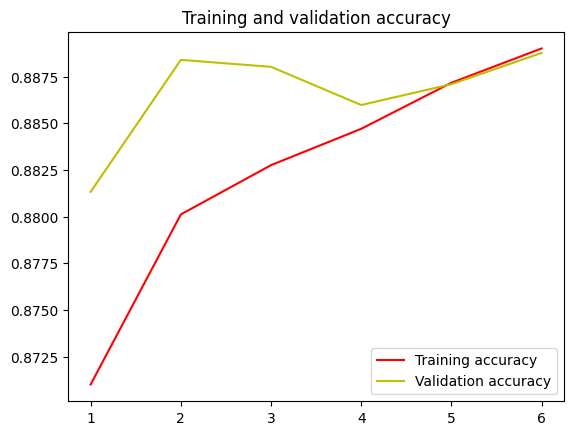

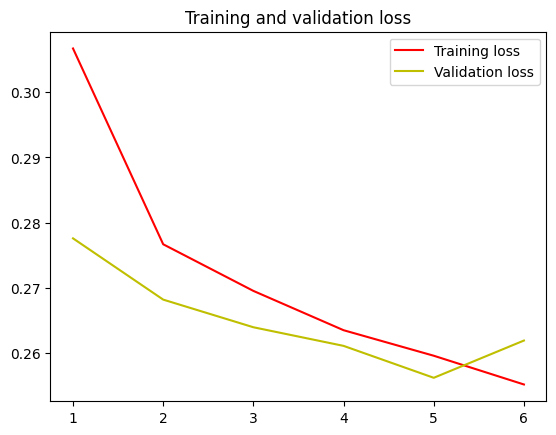

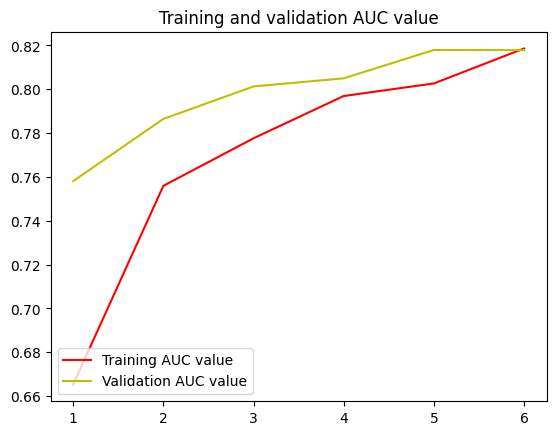

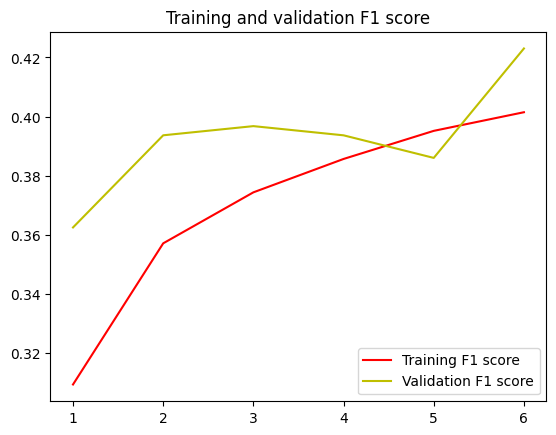

<Figure size 640x480 with 0 Axes>

In [35]:
f1_str = 'f1_at_k'
val_f1_str = 'val_'+f1_str

acc = history.history['accuracy_multilabel']
val_acc = history.history['val_accuracy_multilabel']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history[f1_str]
val_f1 = history.history[val_f1_str]

auc = history.history['auc']
val_auc = history.history['val_auc']

epochs_training = range(1, len(acc)+1)

plt.plot(epochs_training, acc, 'r', label='Training accuracy')
plt.plot(epochs_training, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs_training, loss, 'r', label='Training loss')
plt.plot(epochs_training, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.figure()

plt.plot(epochs_training, auc, 'r', label='Training AUC value')
plt.plot(epochs_training, val_auc, 'y', label='Validation AUC value')
plt.title('Training and validation AUC value')
plt.legend(loc=3)
plt.figure()

plt.plot(epochs_training, f1, 'r', label='Training F1 score')
plt.plot(epochs_training, val_f1, 'y', label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.legend(loc=4)
plt.figure()

plt.show()

In [36]:
model.save('/content/gdrive/MyDrive/Opthamologist/Trained Models/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
